# Introduction



In [1]:
# packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt, log

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor 

#Use R's ggplot style for plots
plt.style.use('ggplot')

# Data Cleaning and Imputation

XXX Text about methods used for data cleaning and imputation. XXX

In [2]:
# load & preview data
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

display(df_train.tail())
print(df_train.shape)
display(df_test.head())
print(df_test.shape)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


(1459, 80)


In [3]:
# examine dependent variable
display(df_train['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

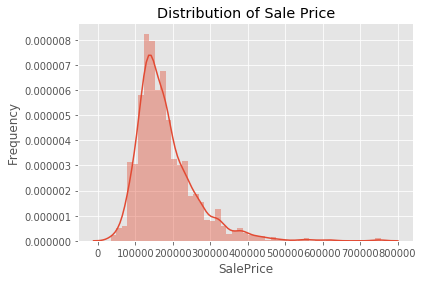

In [4]:
# plot distribution of dependent variable
sns.distplot(df_train['SalePrice'])
plt.title('Distribution of Sale Price')
plt.ylabel('Frequency')
plt.show()

In [5]:
# combine train and test sets
df_combined = pd.concat([df_train.drop('SalePrice', axis = 1), df_test], sort = True)


# check for missing values.
total = df_combined.isnull().sum().sort_values(ascending=False)
percent = (df_combined.isnull().sum()/df_combined.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468


There are 35 fields with missing values, we try to fill them in here. Note it is important to merge training and test sets before checking for missing values. Using only the training set there is only 19 variables with missing values.

### Simple Data Imputation

In [6]:
df_combined = df_combined[df_train.drop('SalePrice', axis = 1).columns]


all_data = df_combined.loc[:, 'Id':'SaleCondition']
display(all_data.head())
print(all_data.shape)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


(2919, 80)


In [7]:
# fill numerical values with their mean
all_data = all_data.fillna(all_data.mean())

# create dummy variables for categoroical data
all_data = pd.get_dummies(all_data)

# examine shape and head of the transformed data set
display(all_data.head())
print(all_data.shape)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,0,0,0,1,0,0,0,0,1,0


(2919, 289)


In [8]:
# check again for missing values.
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
SaleCondition_Partial,0,0.0
Exterior1st_Stone,0,0.0
Condition1_Norm,0,0.0
Condition1_PosA,0,0.0
Condition1_PosN,0,0.0


# Output training and test sets

To be used for modelling


XXX Not sure if this is needed??? XXX

In [9]:
# merge sale price back into training set
train_data = all_data.iloc[0 : len(df_train)]
train_data = train_data.merge(df_train[['Id',  'SalePrice']], on = 'Id')

test_data = all_data.iloc[len(df_train):, ]

# ensure training and test data are the required dimensions.
print('Train data shape:', train_data.shape)
print('Test data shape:', test_data.shape)

Train data shape: (1460, 290)
Test data shape: (1459, 289)


# Preprocessing and Modelling

XXX Text outlining methods to be ussed XXX

In [10]:
# Identify target variable and drop it from the feature matrix.
target = train_data['SalePrice']
X = train_data.drop(['SalePrice', 'Id'], axis = 1)


In [11]:
# function to ensure no negative values are predited
def pos_func(a):
    if (a > 0): return a
    else: return 0
pos_func = np.vectorize(pos_func)

# Scoring function.
# In order to test for kaggle score we must create a function to score predictions as they are scored in the competition rules
def rmse_log(values, predictions):
    delta_preds = pos_func(predictions)

    log_vals = np.log1p(values)
    log_preds = np.log1p(delta_preds)
    
    return sqrt(mean_squared_error(log_vals, log_preds))

In [12]:
# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.3, random_state = 0)
print("X_train dimensions : " + str(X_train.shape))
print("X_test dimensions: " + str(X_test.shape))
print("y_train dimensions: " + str(y_train.shape))
print("y_test dimensions: " + str(y_test.shape))


X_train dimensions : (1022, 288)
X_test dimensions: (438, 288)
y_train dimensions: (1022,)
y_test dimensions: (438,)


## Linear Regression

XXX Text on linear regression based on Intro to stats learning? XXX

The MSE on the training set is 0.10
The MSE on the test set is 1.01


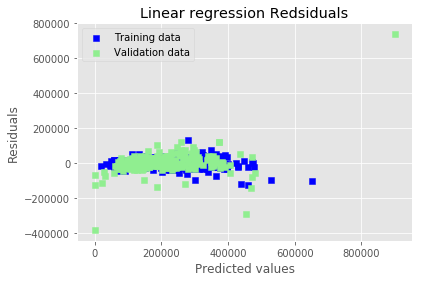

In [13]:
# Intiate and fit a linear regression model.
lr = LinearRegression()
lr.fit(X_train, y_train)

# Preditictions for training and test set.
y_train_pred = pos_func(lr.predict(X_train))
y_test_pred = pos_func(lr.predict(X_test))

# RMSE of log of Sale Price (metric used in the kaggle comp)
train_rmse = rmse_log(y_train, y_train_pred)
test_rmse = rmse_log(y_test, y_test_pred)

# display model fit metrics.
print(f"The MSE on the training set is {train_rmse:,.2f}")
print(f"The MSE on the test set is {test_rmse:,.2f}")

# residuals, diff between predicted and actual values
train_resids = y_train_pred - y_train
test_resids = y_test_pred - y_test

# Plot residuals
plt.scatter(y_train_pred, train_resids, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, test_resids, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression Redsiduals")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend()
plt.show()

In [14]:
# predictions for competitiion submission for linear regression
# get predictions for the holdout test set.
model_predicts = pos_func(lr.predict(test_data.drop('Id', axis = 1)))

# ensure predictions are in the correct format for competition submission
lin_reg_submission = pd.DataFrame({'Id':test_data['Id'], 'SalePrice':model_predicts})
lin_reg_submission = lin_reg_submission.set_index('Id')

# preview submission to ensure format is correct.
display(lin_reg_submission.head())

# save predictions to upload to kaggle.
# lin_reg_submission.to_csv('../submissions/01_simple_models/linear_regression.csv')

,SalePrice
Id,
1461,112288.782465
1462,149046.690576
1463,184233.474788
1464,191708.092867
1465,195144.109001


## Ridge Regression

XXX Text on ridge regression based on Intro to stats learning? XXX

Best parameters: {'alpha': 25}
Best cross-validation score: 0.1528662467661351
Test set score: 0.1493089480710409


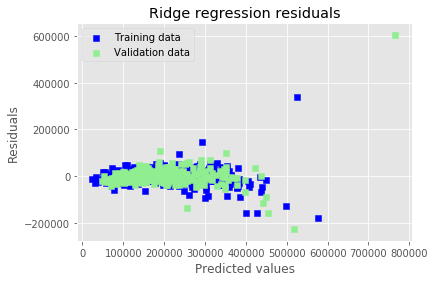

In [42]:
# parameter grid for cross validation for ridge regression.
param_grid = {'alpha' : [0.001, 0.01, 0.1, 1, 10, 25, 50]}

# create scoring function to be used in grid search
my_scorer = make_scorer(rmse_log, greater_is_better = False)

# create grid search and fit
ridge_grid_search = GridSearchCV(Ridge(), param_grid, cv = 5, scoring = my_scorer)
ridge_grid_search.fit(X_train, y_train)

# display model fit parameters.
print('Best parameters: {}'.format(ridge_grid_search.best_params_))
print('Best cross-validation score: {}'.format(-ridge_grid_search.best_score_))
print('Test set score: {}'.format(-ridge_grid_search.score(X_test, y_test)))

# predictions for training and test set.
ridge_train_pred = pos_func(ridge_grid_search.predict(X_train))
ridge_test_pred = pos_func(ridge_grid_search.predict(X_test))

# residuals
ridge_train_resids = ridge_train_pred - y_train
ridge_test_resids = ridge_test_pred - y_test

# Plot residuals
plt.scatter(ridge_train_pred, ridge_train_resids, c = "blue", marker = "s", label = "Training data")
plt.scatter(ridge_test_pred, ridge_test_resids, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Ridge regression residuals")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend()
plt.show()

C:\Users\marko\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


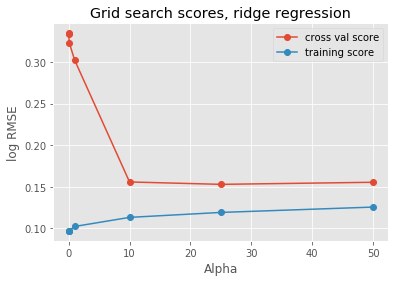

In [65]:
test_scores = np.array(-ridge_grid_search.cv_results_['mean_test_score'])
train_scores = np.array(-ridge_grid_search.cv_results_['mean_train_score'])


alphas = np.array(ridge_grid_search.cv_results_['param_alpha'])

plt.plot(alphas, test_scores, '-o', label = 'cross val score')
plt.plot(alphas, train_scores, '-o', label = 'training score')
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('log RMSE')
plt.title('Grid search scores, ridge regression')
plt.show()

In [29]:
# predictions for comp entry.
ridge_grid_predicts = pos_func(ridge_grid_search.predict(test_data.drop('Id', axis = 1)))

# ensure predictions are in the correct format for competition submission
ridge_grid_submission = pd.DataFrame({'Id':test_data['Id'], 'SalePrice':ridge_grid_predicts})
ridge_grid_submission = ridge_grid_submission.set_index('Id')

# preview submission
display(ridge_grid_submission.head())

# save predictions to upload to kaggle.
# ridge_grid_submission.to_csv('../submissions/01_simple_models/ridge_grid_regression.csv')

,SalePrice
Id,
1461,109561.941328
1462,156971.394910
1463,180458.157838
1464,192610.445618
1465,189998.293009


## Lasso Regression

XXX Text on lasso regression based on Intro to stats learning? XXX

Best parameters: {'alpha': 175}
Best cross-validation score: 0.1461
Test set score: 0.1553


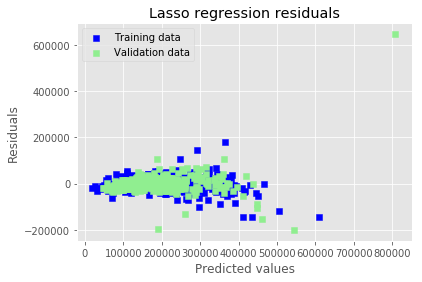

In [58]:
# parameter grid for cross validation for lasso regression.
param_grid = {'alpha' : [50, 75, 100, 125, 150, 175, 200, 250]}

# grid search and fit lasso
lasso_grid_search = GridSearchCV(Lasso(max_iter=100000), param_grid, cv = 5, scoring = my_scorer)
lasso_grid_search.fit(X_train, y_train)

# display model fit parameters.
print('Best parameters: {}'.format(lasso_grid_search.best_params_))
print('Best cross-validation score: {0:.4f}'.format(-lasso_grid_search.best_score_))
print('Test set score: {0:.4f}'.format(-lasso_grid_search.score(X_test, y_test)))

# predictions for training and test set.
lasso_train_pred = pos_func(lasso_grid_search.predict(X_train))
lasso_test_pred = pos_func(lasso_grid_search.predict(X_test))

# residuals
lasso_train_resids = lasso_train_pred - y_train
lasso_test_resids = lasso_test_pred - y_test

# Plot residuals
plt.scatter(lasso_train_pred, lasso_train_resids, c = "blue", marker = "s", label = "Training data")
plt.scatter(lasso_test_pred, lasso_test_resids, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Lasso regression residuals")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()

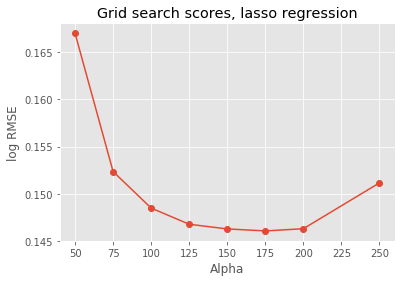

In [60]:
scores = np.array(-lasso_grid_search.cv_results_['mean_test_score'])

alphas = np.array(lasso_grid_search.cv_results_['param_alpha'])

plt.plot(alphas, scores, '-o')
plt.xlabel('Alpha')
plt.ylabel('log RMSE')
plt.title('Grid search scores, lasso regression')
plt.show()

In [31]:
# predictions
lasso_grid_predicts = pos_func(lasso_grid_search.predict(test_data.drop('Id', axis = 1)))

# ensure predictions are in the correct format for competition submission
lasso_grid_submission = pd.DataFrame({'Id':test_data['Id'], 'SalePrice':lasso_grid_predicts})
lasso_grid_submission = lasso_grid_submission.set_index('Id')

# preview submission
display(lasso_grid_submission.head())

# save predictions to upload to kaggle.
# lasso_grid_submission.to_csv('../submissions/01_simple_models/lasso_grid_regression.csv')

,SalePrice
Id,
1461,117006.130717
1462,158428.633718
1463,182402.538433
1464,193622.545303
1465,196424.381211


## Simple Regression Tree

XXX Text on regression trees based on Intro to stats learning? XXX

Training set log rmse score: 0.0000
Test set log rmse score: 0.1973


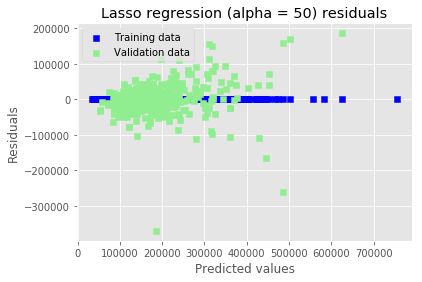

In [61]:
# create a regressor object 
reg_tree = DecisionTreeRegressor()  
  
# fit the regressor with X and Y data 
reg_tree.fit(X_train, y_train) 

# predictions for training and test set.
reg_tree_train_pred = (reg_tree.predict(X_train))
reg_tree_test_pred = pos_func(reg_tree.predict(X_test))

# RMSE of log of Sale Price
reg_tree_train_rmse = rmse_log(y_train, reg_tree_train_pred)
reg_tree_test_rmse = rmse_log(y_test, reg_tree_test_pred)

# display model fit metrics.
print('Training set log rmse score: {0:.4f}'.format(reg_tree_train_rmse))
print('Test set log rmse score: {0:.4f}'.format(reg_tree_test_rmse))

# residuals
reg_tree_train_resids = reg_tree_train_pred - y_train
reg_tree_test_resids = reg_tree_test_pred - y_test

# Plot residuals
plt.scatter(reg_tree_train_pred, reg_tree_train_resids, c = "blue", marker = "s", label = "Training data")
plt.scatter(reg_tree_test_pred, reg_tree_test_resids, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Lasso regression (alpha = 50) residuals")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()

In [33]:
# predictions
reg_tree_predicts = pos_func(reg_tree.predict(test_data.drop('Id', axis = 1)))

# ensure predictions are in the correct format for competition submission
reg_tree_submission = pd.DataFrame({'Id':test_data['Id'], 'SalePrice':reg_tree_predicts})
reg_tree_submission = reg_tree_submission.set_index('Id')

# preview submission
display(reg_tree_submission.head())

# save predictions to upload to kaggle.
# reg_tree_submission.to_csv('../submissions/01_simple_models/reg_tree_regression.csv')

,SalePrice
Id,
1461,119000.0
1462,142000.0
1463,175000.0
1464,169000.0
1465,174000.0


## Ensemble model

XXX short discussion on ensemble models XXX

In [34]:
# weight each prediction according to the following weights.
w1 = 1/3
w2 = 1/3
w3 = 1/3
ensemble_sub = (w1 * ridge_grid_submission) + (w2 * lasso_grid_submission) + (w3 * reg_tree_submission)

display(ensemble_sub.head())
# ensemble_sub.to_csv('../submissions/01_simple_models/ensemble_sub.csv')

,SalePrice
Id,
1461,115189.357348
1462,152466.676210
1463,179286.898757
1464,185077.663640
1465,186807.558073


# Kaggle Results

linear regression:  0.56569

lasso regression: 0.14915

ridge regression: 0.15793

regression tree: 0.22145

ensemble model: 0.13744
